<h1 style="text-align: center; color: #4CAF50;">
FAIRCheck: Lightweight Validator for Zenodo, GitHub, and Zotero
</h1>

# Data & Publication Validation Tool

This notebook provides a **lightweight and reliable validation tool** to help ensure that scientific products and datasets are:

- Properly archived on platforms like **Zenodo**, **GitHub**, and **Zotero**
- Published with identifiers such as DOIs
- Compliant with standardized file naming and metadata conventions

---

## Key Features

### Automated Validation Checks
- **Layer verification**: Randomly samples 500 spatial points from raster/vector data to confirm file integrity.
- **Zenodo cross-check**: Uses the Zenodo API to validate dataset entries (e.g., existence, metadata, DOI).
- **GitHub checks** *: Confirms that repositories are publicly accessible and contain expected content.

---

### Standardized File Naming
- Implements and validates file names based on a OEMC convention (e.g., `variable_method_type_resolution_depth_dates_bbox_epsg_version.tif`).
- Flags improperly formatted filenames for correction.

---

### Manual Review Flags
Some aspects still require human validation and are flagged for manual review, including:
- Completeness and clarity of metadata
- Quality and interpretability of titles, abstracts, and keywords
- Proper attribution and license declarations

In [73]:
import re
from datetime import datetime
import rasterio
from rasterio.vrt import WarpedVRT
from rasterio.session import AWSSession
from rasterio.io import MemoryFile
from rasterio.enums import Resampling
from shapely.geometry import Point
import geopandas as gpd
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# Naming convention

In [ ]:
def check_filename(filename):
    if not filename.endswith(".tif"):
        return False, "File extension is not .tif"

    name = filename[:-4]
    rest = name.split("_")
    # ------------------------------------------------------------------------
    # Extract each part
    generic_var, method_proc, var_type, spatial_support, depth_ref, date_start, date_end, bbox, epsg, version = rest

    # Generic variable name ('lclu')
    # No check implemented!

    # Method/procedure (e.g., 'luisa')
    # No check implemented!
    # ------------------------------------------------------------------------
    # Variable type or position (c, p05, mean)
    if var_type not in ["c","m","sd","p","p05","p50","p95"]:
        return False, f"Invalid variable type: {var_type}"
    # ------------------------------------------------------------------------
    # Spatial resolution (30m, 1km)
    if not re.fullmatch(r"\d+(m|km)", spatial_support):
        return False, f"Invalid spatial support: {spatial_support}"
    # ------------------------------------------------------------------------
    # Depth reference (s, b0-30, a0-10)
    if not re.fullmatch(r"[sab]\d*(-\d*)?$", depth_ref) and depth_ref != 's':
        return False, f"Invalid depth reference: {depth_ref}"
    # ------------------------------------------------------------------------
    # Start and end dates in YYYYMMDD
    try:
        start_dt = datetime.strptime(date_start, "%Y%m%d")
    except ValueError:
        return False, f"Invalid start date: {date_start}"
    try:
        end_dt = datetime.strptime(date_end, "%Y%m%d")
    except ValueError:
        return False, f"Invalid end date: {date_end}"
    if start_dt > end_dt:
        return False, f"Start date {date_start} is after end date {date_end}"
    # ------------------------------------------------------------------------
    # Bounding box (2 lowercase letters)
    if bbox not in ['go','eu']:
        return False, f"Invalid bounding box code: {bbox}"
    # ------------------------------------------------------------------------
    # EPSG code (epsg.4326 or 3035)
    if epsg not in ['4326','3035']:
        return False, f"Invalid EPSG code: {epsg}"
    # ------------------------------------------------------------------------
    # Version code (v20221015)
    if not re.fullmatch(r"v\d{8}", version):
        return False, f"Invalid version format: {version}"

    return True, "Filename is valid according to OEMC naming convention."

# Example use
cog_url = "http://192.168.1.30:8333/gpw/arco/gpw_ugpp.daily_lue.model_m_30m_s_20221101_20221231_go_epsg.4326_v1.tif"
filename = cog_url.split("/")[-1]
print(f"Filename: {filename}")

is_valid, message = check_filename(filename)
print("Valid!" if is_valid else "Not valid!", message)

In [88]:
import re
from datetime import datetime

def check_filename(filename):
    if not filename.endswith(".tif"):
        return False, "File extension is not .tif"

    name = filename[:-4]  # Remove '.tif'
    parts = name.split("_")

    if len(parts) < 9:
        return False, "Filename has too few components"

    # Take the last 9 expected parts
    version = parts[-1]
    epsg = parts[-2]
    bbox = parts[-3]
    date_end = parts[-4]
    date_start = parts[-5]
    depth_ref = parts[-6]
    spatial_support = parts[-7]
    var_type = parts[-8]
    method_proc = parts[-9]

    # variable name: everything to the left of method_proc (not validated)
    generic_var = "_".join(parts[:-9])

    # ------------------------------------------------------------------------
    # Variable type or position (c, p05, mean)
    if var_type not in ["c", "m", "sd", "p", "p05", "p50", "p95"]:
        return False, f"Invalid variable type: {var_type}"
    # ------------------------------------------------------------------------
    # Spatial resolution (e.g., 30m, 1km)
    if not re.fullmatch(r"\d+(m|km)", spatial_support):
        return False, f"Invalid spatial support: {spatial_support}"
    # ------------------------------------------------------------------------
    # Depth reference (e.g., s, b0-30, a0-10)
    if not re.fullmatch(r"[sab]\d*(-\d*)?$", depth_ref) and depth_ref != 's':
        return False, f"Invalid depth reference: {depth_ref}"
    # ------------------------------------------------------------------------
    # Start and end dates (YYYYMMDD)
    try:
        start_dt = datetime.strptime(date_start, "%Y%m%d")
    except ValueError:
        return False, f"Invalid start date: {date_start}"
    try:
        end_dt = datetime.strptime(date_end, "%Y%m%d")
    except ValueError:
        return False, f"Invalid end date: {date_end}"
    if start_dt > end_dt:
        return False, f"Start date {date_start} is after end date {date_end}"
    # ------------------------------------------------------------------------
    # Bounding box
    if bbox not in ['go', 'eu']:
        return False, f"Invalid bounding box code: {bbox}"
    # ------------------------------------------------------------------------
    # EPSG code
    if epsg not in ['4326', '3035']:
        return False, f"Invalid EPSG code: {epsg}"
    # ------------------------------------------------------------------------
    # Version (e.g., v20221015)
    if not re.fullmatch(r"v\d{8}", version):
        return False, f"Invalid version format: version"
    print("-"*100)
    print("\033[91m Variable name: \033[0m", generic_var)
    print("-"*100)
    print("\033[91m Method name: \033[0m", method_proc)
    print("-"*100)
    print("\033[91m Variable type: \033[0m", var_type)
    print("-"*100)
    print("\033[91m Spatial support: \033[0m", spatial_support)
    print("-"*100)
    print("\033[91m Depth reference: \033[0m", depth_ref)
    print("-"*100)
    print("\033[91m Start date: \033[0m", start_dt)
    print("-"*100)
    print("\033[91m End date: \033[0m", end_dt)
    print("-"*100)
    print("\033[91m Bounding box: \033[0m", bbox)
    print("-"*100)
    print("\033[91m EPSG code: \033[0m", epsg)
    print("-"*100)
    print("\033[91m Version: \033[0m", version)
    print("-"*100)
    return True, "Filename is valid according to OEMC naming convention."

# Example
cog_url = "http://192.168.1.30:8333/gpw/arco/gpw_ugpp.daily_lue.model_m_30m_s_20221101_20221231_go_4326_v20221015.tif"
filename = cog_url.split("/")[-1]
print(f"Filename: {filename}")

is_valid, message = check_filename(filename)
print("Valid!" if is_valid else "Not valid!", message)


Filename: gpw_ugpp.daily_lue.model_m_30m_s_20221101_20221231_go_4326_v20221015.tif
----------------------------------------------------------------------------------------------------
 Variable name:  gpw_ugpp.daily
----------------------------------------------------------------------------------------------------
 Method name:  lue.model
----------------------------------------------------------------------------------------------------
 Variable type:  m
----------------------------------------------------------------------------------------------------
 Spatial support:  30m
----------------------------------------------------------------------------------------------------
 Depth reference:  s
----------------------------------------------------------------------------------------------------
 Start date:  2022-11-01 00:00:00
----------------------------------------------------------------------------------------------------
 End date:  2022-12-31 00:00:00
------------------------

# Overlay with global/EU points to check validity of pixels

In [17]:
epsg_code = re.search(r'(?<=_epsg\.)\d+', cog_url).group(0)
if epsg_code == "4326":
    points = gpd.read_file("global_testing_points.gpkg")
elif epsg_code == "3035":
    points = gpd.read_file("eu_testing_points.gpkg")
else:
    raise Warning(f"Wrong EPSG used! EPSG code: {epsg_code}")

values = []

count = 0
with rasterio.open(cog_url) as src:
    for pt in tqdm(points.geometry):
        for value in src.sample([(pt.x, pt.y)]):
            values.append(value[0])
        count += 1
points["value"] = values

  0%|          | 0/500 [00:00<?, ?it/s]

# Visual check of Pixel Values

Check the distribution of the values and make sure pixel values are within proper range. This step is done manually by product owner

1) Histogram of pixel values
2) Map of pixel values

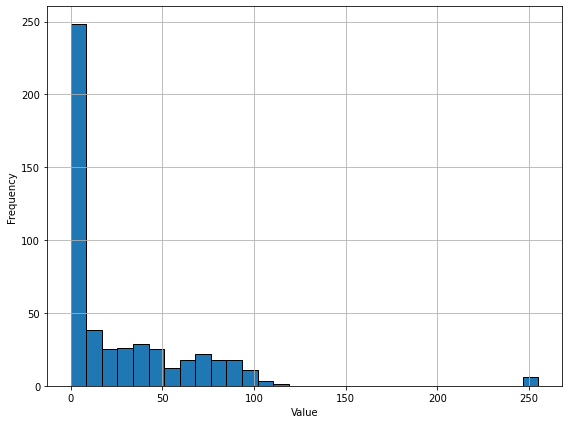

In [18]:
plt.figure(figsize=(8, 6))
plt.hist(points["value"], bins=30, edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

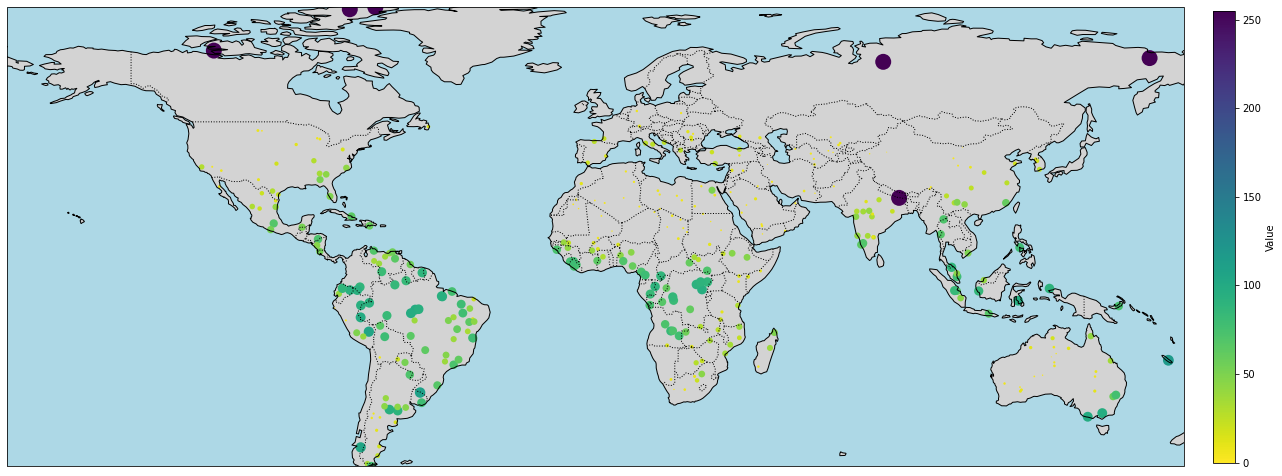

In [27]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

plt.figure(figsize=(20, 16))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.coastlines(resolution='110m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

points["lon"] = points.geometry.x
points["lat"] = points.geometry.y

min_lon, max_lon = points["lon"].min(), points["lon"].max()
min_lat, max_lat = points["lat"].min(), points["lat"].max()
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

sc = plt.scatter(points["lon"], points["lat"],
                 c=points["value"],
                 cmap="viridis_r",  
                 s=points["value"], edgecolor='none',
                 transform=ccrs.PlateCarree())

cbar = plt.colorbar(sc, ax=ax, orientation="vertical", shrink=0.4, pad=0.02)
cbar.set_label('Value')

plt.tight_layout()
plt.show()


# Check zenodo entry

In [98]:
import requests

def check_zenodo_metadata(doi_or_id):
    if doi_or_id.startswith("10."):
        doi_url = f"https://doi.org/{doi_or_id}"
        resp = requests.get(doi_url, allow_redirects=True)
        if resp.status_code != 200:
            return f"DOI failed: {doi_or_id}"
        record_url = resp.url
        record_url = f"https://zenodo.org/api/records/{doi_or_id.split('.')[-1]}"
    else:
        return f"DOI/Zenodo link failed: {doi_or_id}"

    # Read metadata
    response = requests.get(record_url)
    if response.status_code != 200:
        return f"ould not fetch Zenodo record: {response.status_code}"

    data = response.json()["metadata"]

    # Check key metadata fields
    required_fields = ['title', 'creators', 'description', 'license', 'publication_date']
    missing_fields = [f for f in required_fields if f not in data or not data[f]]

    # Check keywords and related identifiers
    warnings = []
    if 'keywords' not in data or not data['keywords']:
        warnings.append("Missing keywords")
    if 'related_identifiers' not in data:
        warnings.append("No related identifiers (e.g., DOI links to code or articles)")

    if missing_fields:
        return f"Missing required fields: {', '.join(missing_fields)}"
    return f"Metadata OK\n" + "\n".join(warnings), data

In [99]:
_, data = check_zenodo_metadata("10.5281/zenodo.13890401")

print("-"*100)
print("\033[91m Product name: \033[0m", data['title'])
print("-"*100)
print("\033[91m DOI: \033[0m", data["doi"])
print("-"*100)
print("\033[91m Publication Date: \033[0m", data["publication_date"])
print("-"*100)
print("\033[91m Authors: \033[0m", ", ".join(person["name"] for person in data["creators"]))
print("-"*100)
print("\033[91m Version: \033[0m", data["version"])
print("-"*100)
print("\033[91m Funding information: \033[0m")
for item in data["grants"]:
    print(" Title:   ", item.get('title'))
    print(" Code:    ", item.get('code'))
    print(" URL:     ", item.get('url'))
    print(" Funder:  ", item['funder'].get('name'))
    if 'acronym' in item:
        print(" Acronym: ", item['acronym'])
    if 'program' in item:
        print(" Program: ", item['program'])
    print("-" * 40)
print("-"*100)
print("\033[91m License: \033[0m", data["license"]["id"])
print("-"*100)

publication = [item for item in data["related_identifiers"] if item["resource_type"]=='publication']
print("\033[91m Publication: \033[0m", end="")
for item in publication:
    print(item["identifier"])
print("-"*100)
print("\033[91m Software: \033[0m", data["custom"]["code:codeRepository"])
print("-"*100)



----------------------------------------------------------------------------------------------------
 Product name:  Global Pasture Watch - Annual grassland class and extent maps at 30-m spatial resolution (2000—2022)
----------------------------------------------------------------------------------------------------
 DOI:  10.5281/zenodo.13890401
----------------------------------------------------------------------------------------------------
 Publication Date:  2024-10-10
----------------------------------------------------------------------------------------------------
 Authors:  Leandro Parente, Lindsey Sloat, Vinicius Mesquita, Davide Consoli, Radost Stanimirova, Tomislav Hengl, Carmelo Bonannella, Nathália Teles, Ichsani Wheeler, Maria Hunter, Steffen Ehrmann, Laerte Ferreira, Ana Paula Mattos, Bernard Oliveira, Carsten Meyer, Murat Şahin, Martijn Witjes, Steffen Fritz, Žiga Malek, Fred Stolle
-----------------------------------------------------------------------------------